In [ ]:
from Imports import *
from Plotting import *
from Helper import *
from Preprocessing import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
jet_images_path = '../data/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
jet_mass_data = HDF5File(jet_images_path, 'r')

print(jet_mass_data.keys())
print(jet_mass_data['image'].shape)

<KeysViewHDF5 ['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']>
(872666, 25, 25)


In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim

        self.noise = GaussianNoise(sigma=0.2)

        self.feature_gen = nn.Sequential(
            nn.Linear(9, 256),
            nn.LayerNorm(256),
            self.noise
        )

        self.image_gen1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 1x1 → 2x2
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 2x2 → 4x4
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),     # 4x4 → 8x8
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )

        self.image_gen4 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     # 8x8 → 16x16
            nn.Sigmoid()
        )

    def forward(self, z_feat):
        img = self.feature_gen(z_feat)
        # print(img.shape)
        img = img.view(-1, 256, 1, 1)
        # print(img.shape)
        img = self.image_gen1(img)
        # print(img.shape)
        img = self.image_gen2(img)
        # print(img.shape)
        img = self.image_gen3(img)
        # print(img.shape)
        img = self.image_gen4(img)
        # print(img.shape)
        img = soft_threshold(img, threshold=0.001, sharpness=1000.0)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Flattened image: 16x16 = 256
        self.image_encoder = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Flatten()
        )

        self.feature_encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
        )

        # Dynamically get input dimensions
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 16, 16)
            flat_dim = self.image_encoder(dummy).shape[1] + 64

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, img, features):
        img_encoded = self.image_encoder(img)
        feat_encoded = self.feature_encoder(features)
        combined = torch.cat((img_encoded, feat_encoded), dim=1)

        # print(img_encoded.shape)
        # print(feat_encoded.shape)
        # print(combined.shape[-1])

        prob = self.classifier(combined)

        return prob  # Shape: (batch_size, 1)

Image shape: torch.Size([872666, 16, 16])
dR Mean: torch.Size([872666])
dR STD: torch.Size([872666])
Pixel Mean: torch.Size([872666])
Pixel STD: torch.Size([872666])
ΔR min: 0.0
ΔR max: 2.4713454246520996
ΔR mean min: 0.003572926390916109
ΔR mean max: 0.015763528645038605
ΔR std min: 0.017520317807793617
ΔR std max: 0.16022197902202606
Weights (pixel intensity) min: 0.0
Weights (pixel intensity) max: 1.0
Pixel mean min: 0.0028264394495636225
Pixel mean max: 0.004322932101786137
Pixel std min: 0.008012386038899422
Pixel std max: 0.06249340996146202


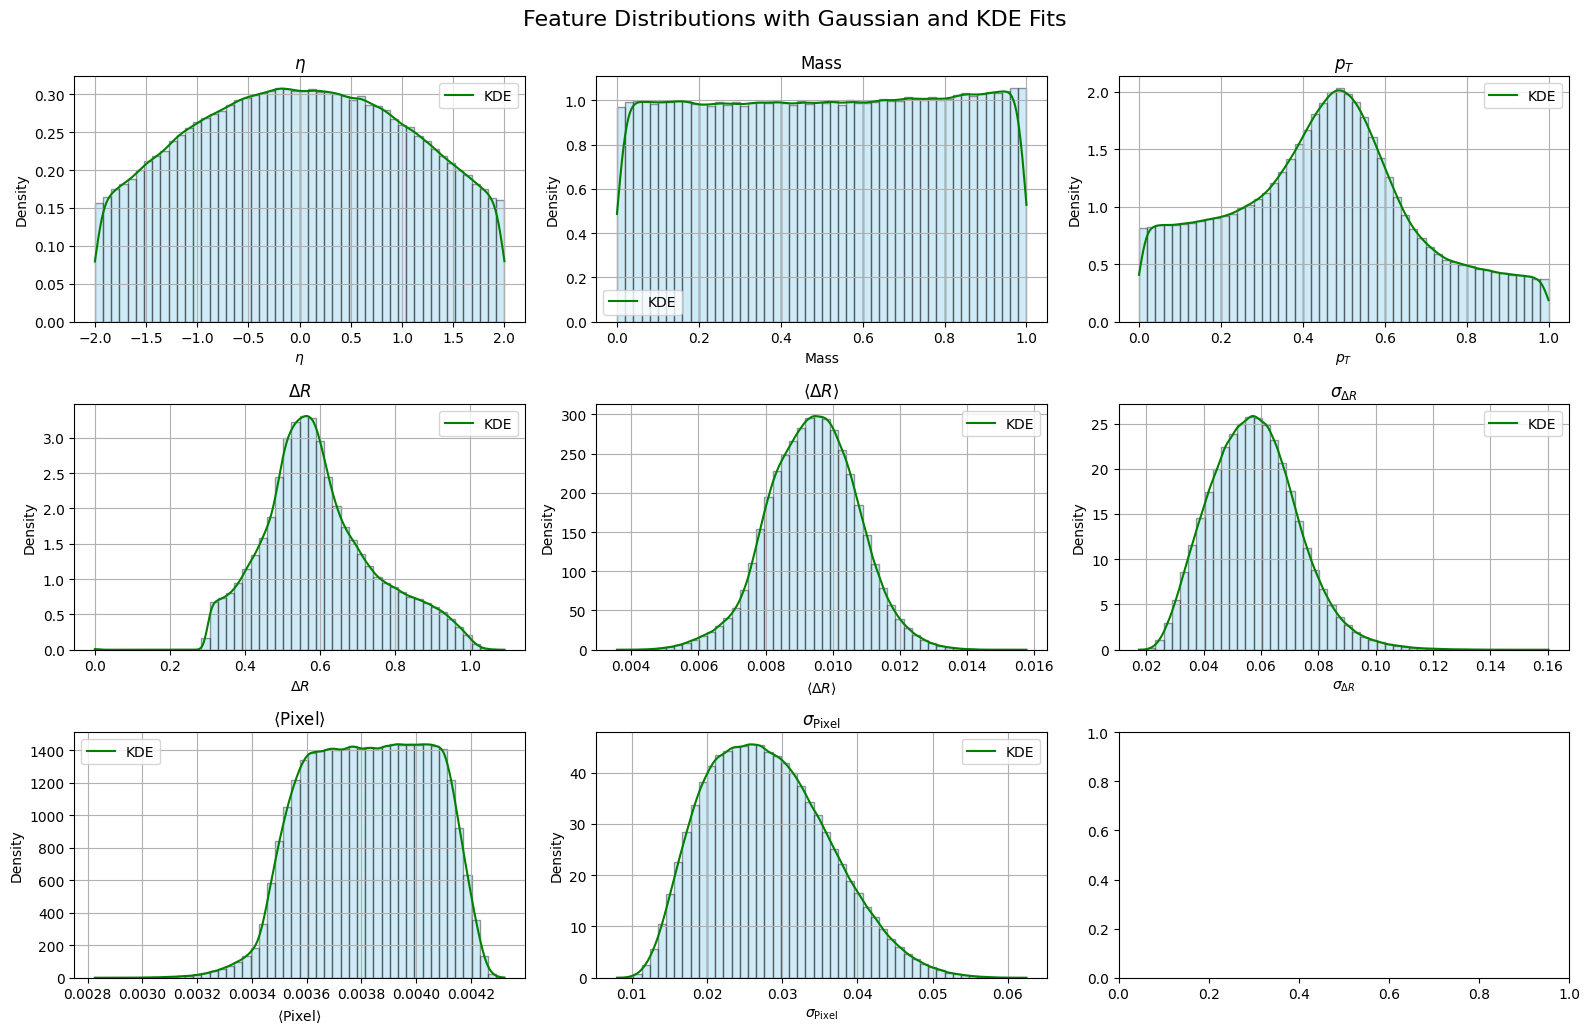

Number of samples: 872666
Image shape: torch.Size([872666, 16, 16])
Feature shape: torch.Size([872666, 9])


In [7]:
batch_size = 128*3
n_events = int(1 * jet_mass_data['image'].shape[0])

dataset = JetDataset(jet_mass_data, n_events)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

kdes = feature_distributions(dataset)

print("Number of samples:", len(dataset))
print("Image shape:", dataset.images.shape)
print("Feature shape:", dataset.features.shape)

[Epoch 1/300] [D loss: 0.8350] [G loss: 0.2711] [Validity_loss: 0.1261] 
 [Stat_loss: 0.1150] [NNZ_loss: 0.0300]
Sample feature coding: [1.         1.6074688  0.10680228 0.14972396 0.5358493  0.00585682
 0.03589323 0.00383046 0.0193056 ]


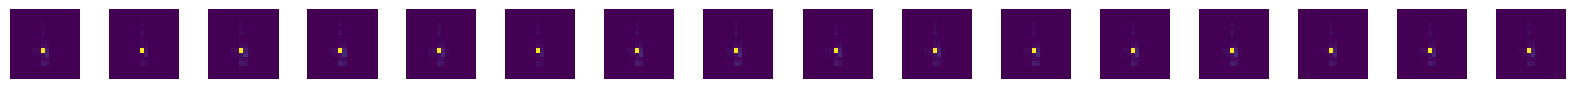

[Epoch 2/300] [D loss: 0.8542] [G loss: 0.3553] [Validity_loss: 0.1222] 
 [Stat_loss: 0.2159] [NNZ_loss: 0.0171]
Sample feature coding: [ 1.         -1.0387703   0.32904166  0.07087255  0.60746014  0.00861358
  0.06499912  0.00388223  0.01846506]


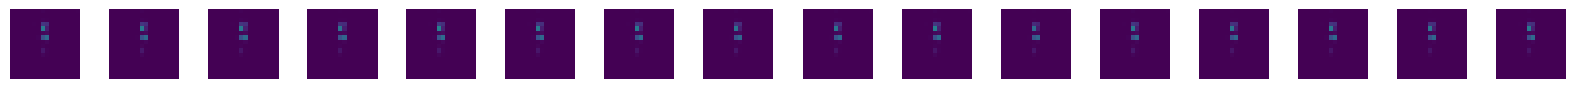

[Epoch 3/300] [D loss: 0.6619] [G loss: 0.3423] [Validity_loss: 0.1464] 
 [Stat_loss: 0.1778] [NNZ_loss: 0.0181]
Sample feature coding: [ 0.         -1.7221161   0.08436628  0.5102646   0.67099065  0.00988586
  0.07570592  0.00390623  0.02109867]


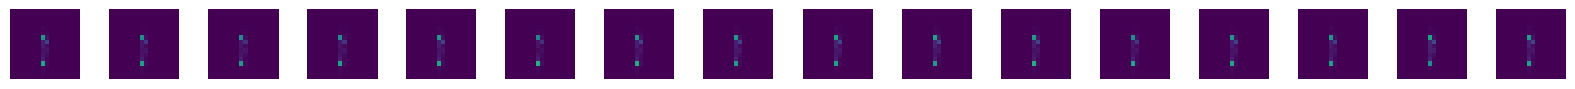

[Epoch 4/300] [D loss: 0.6358] [G loss: 0.4189] [Validity_loss: 0.1518] 
 [Stat_loss: 0.2484] [NNZ_loss: 0.0187]
Sample feature coding: [0.         0.9645353  0.57632434 0.1886763  0.5309062  0.00980829
 0.05074084 0.00374567 0.02362694]


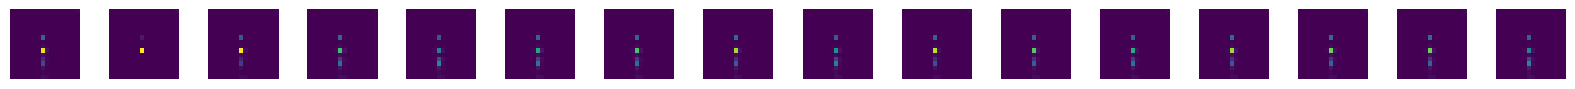

[Epoch 5/300] [D loss: 0.6374] [G loss: 0.4985] [Validity_loss: 0.1570] 
 [Stat_loss: 0.3156] [NNZ_loss: 0.0258]
Sample feature coding: [0.         1.2017448  0.12811886 0.71859366 0.4748806  0.01094277
 0.07451797 0.00379033 0.01526431]


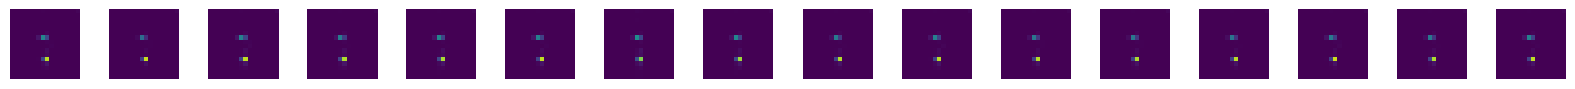

[Epoch 6/300] [D loss: 0.6316] [G loss: 0.2166] [Validity_loss: 0.1174] 
 [Stat_loss: 0.0883] [NNZ_loss: 0.0109]
Sample feature coding: [ 1.         -0.7341148   0.7833581   0.07505527  0.6271077   0.01105816
  0.05928475  0.00374906  0.01921399]


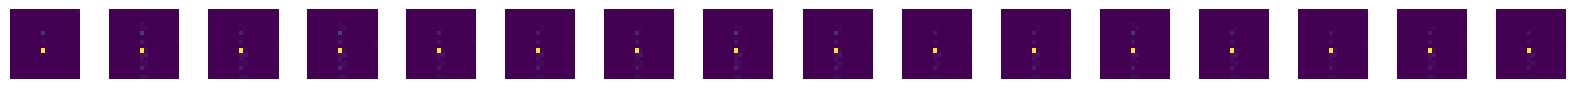

[Epoch 7/300] [D loss: 0.6732] [G loss: 0.5017] [Validity_loss: 0.2034] 
 [Stat_loss: 0.2724] [NNZ_loss: 0.0260]
Sample feature coding: [ 0.         -0.74359566  0.7675494   0.52519226  0.6435333   0.0071015
  0.04409868  0.00368038  0.01942181]


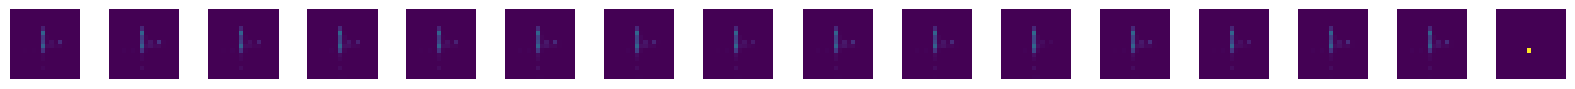

[Epoch 8/300] [D loss: 0.3125] [G loss: 0.2962] [Validity_loss: 0.1967] 
 [Stat_loss: 0.0878] [NNZ_loss: 0.0117]
Sample feature coding: [1.         0.45377785 0.5852644  0.6413421  0.53164136 0.0090946
 0.05090147 0.00346969 0.03183315]


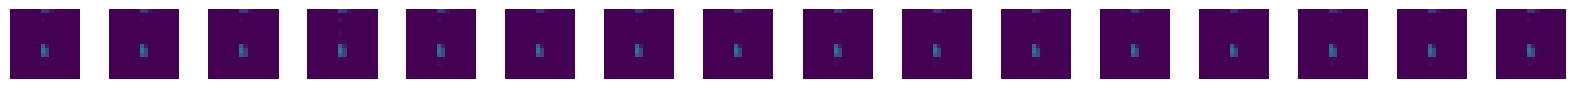

[Epoch 9/300] [D loss: 0.4615] [G loss: 0.2797] [Validity_loss: 0.1596] 
 [Stat_loss: 0.1081] [NNZ_loss: 0.0120]
Sample feature coding: [ 1.         -0.15887985  0.99581033  0.39472967  0.5860888   0.01053579
  0.08652186  0.00378562  0.02705406]


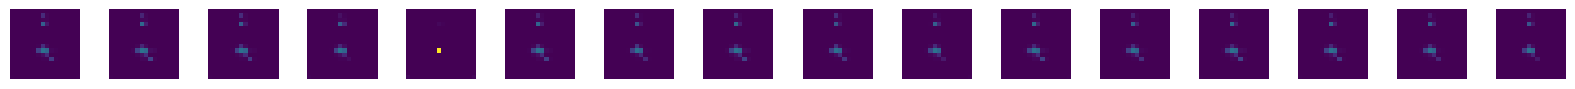

[Epoch 10/300] [D loss: 0.4604] [G loss: 0.2573] [Validity_loss: 0.1530] 
 [Stat_loss: 0.0929] [NNZ_loss: 0.0114]
Sample feature coding: [ 1.         -0.9217034   0.3732708   0.18177812  0.7871069   0.00822403
  0.04027914  0.00370372  0.02715269]


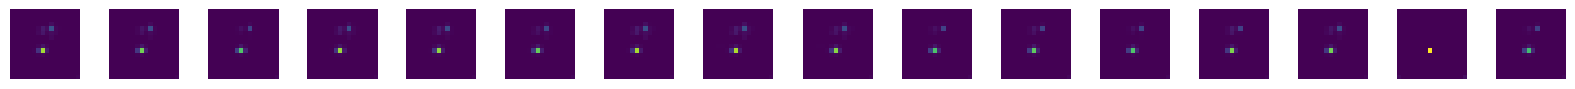

[Epoch 11/300] [D loss: 0.4037] [G loss: 0.4382] [Validity_loss: 0.1931] 
 [Stat_loss: 0.2267] [NNZ_loss: 0.0184]
Sample feature coding: [1.         0.5295743  0.22404204 0.4848698  0.5453092  0.01064927
 0.07238423 0.00416016 0.03747629]


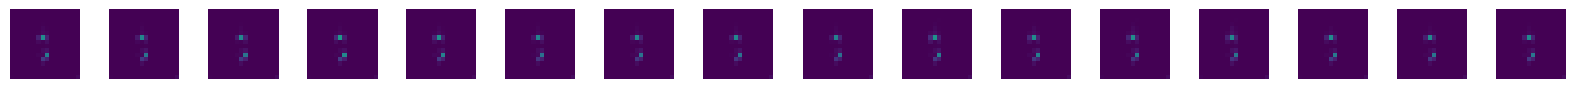

[Epoch 12/300] [D loss: 0.4116] [G loss: 0.2668] [Validity_loss: 0.1651] 
 [Stat_loss: 0.0914] [NNZ_loss: 0.0103]
Sample feature coding: [0.         0.700602   0.43703026 0.35823548 0.75251114 0.00918975
 0.07884754 0.00411788 0.04423396]


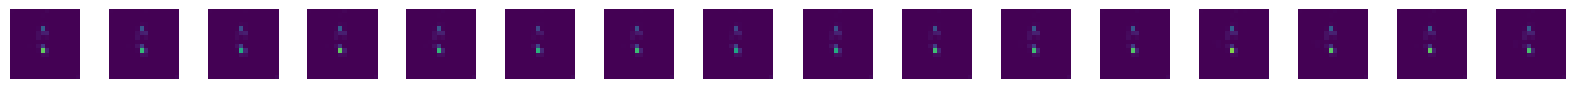

[Epoch 13/300] [D loss: 0.6313] [G loss: 0.1953] [Validity_loss: 0.0954] 
 [Stat_loss: 0.0887] [NNZ_loss: 0.0112]
Sample feature coding: [ 0.         -1.8981801   0.12707108  0.3108884   0.57027584  0.00961566
  0.05304921  0.00417056  0.03562532]


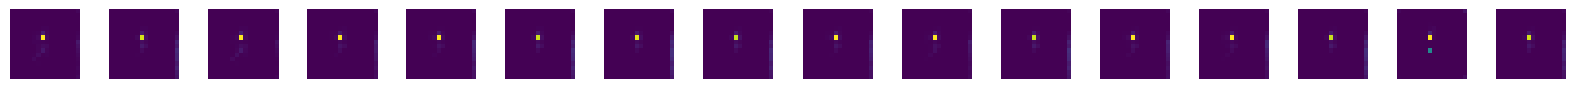

[Epoch 14/300] [D loss: 0.4829] [G loss: 0.2422] [Validity_loss: 0.1430] 
 [Stat_loss: 0.0884] [NNZ_loss: 0.0109]
Sample feature coding: [0.         1.883521   0.21347384 0.5985794  0.34563228 0.01124945
 0.04374509 0.00393524 0.01647977]


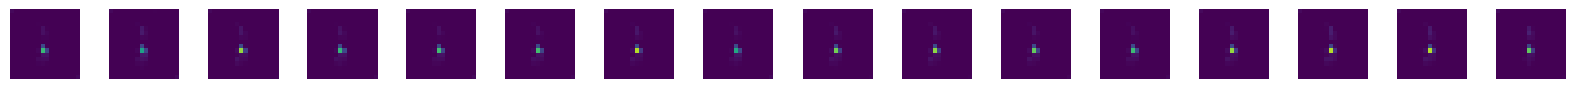

[Epoch 15/300] [D loss: 0.6921] [G loss: 0.2413] [Validity_loss: 0.1430] 
 [Stat_loss: 0.0882] [NNZ_loss: 0.0102]
Sample feature coding: [1.         1.3537122  0.12575905 0.04108411 0.6828669  0.01103323
 0.03361234 0.00361013 0.02392564]


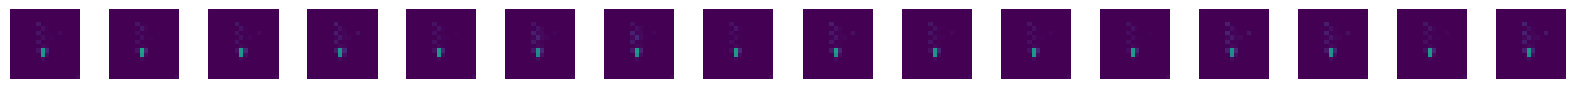

[Epoch 16/300] [D loss: 0.6614] [G loss: 0.3690] [Validity_loss: 0.1248] 
 [Stat_loss: 0.2281] [NNZ_loss: 0.0160]
Sample feature coding: [1.         1.9020864  0.28755638 0.47396693 0.43170166 0.0058999
 0.06503209 0.0037456  0.0326167 ]


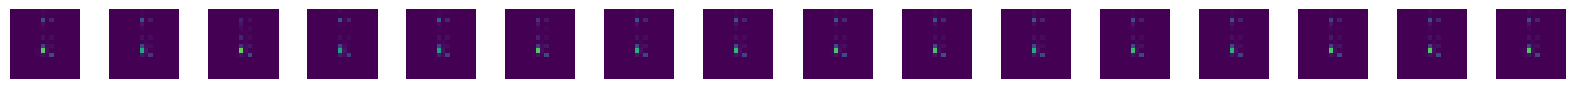

[Epoch 17/300] [D loss: 0.2968] [G loss: 0.5047] [Validity_loss: 0.2353] 
 [Stat_loss: 0.2559] [NNZ_loss: 0.0135]
Sample feature coding: [0.         0.73111993 0.6664535  0.81088936 0.42076358 0.0099543
 0.05149169 0.00399923 0.0266952 ]


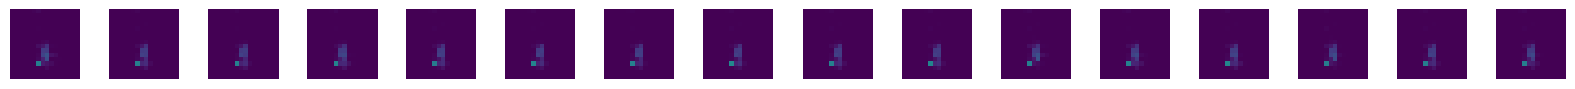

[Epoch 18/300] [D loss: 0.6661] [G loss: 0.2272] [Validity_loss: 0.1272] 
 [Stat_loss: 0.0885] [NNZ_loss: 0.0114]
Sample feature coding: [ 1.         -1.4632764   0.60060346  0.37862483  0.42971256  0.00912965
  0.06045392  0.00368658  0.02921266]


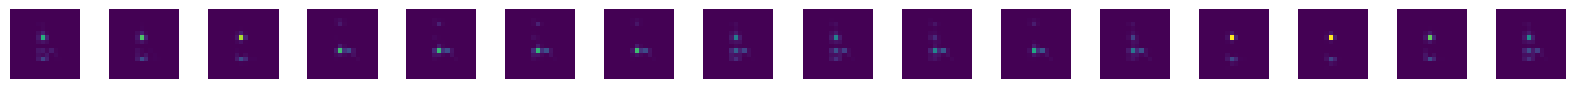

[Epoch 19/300] [D loss: 0.5320] [G loss: 0.4284] [Validity_loss: 0.1567] 
 [Stat_loss: 0.2589] [NNZ_loss: 0.0128]
Sample feature coding: [0.         0.56326723 0.12535241 0.15494886 0.4807335  0.00867147
 0.063407   0.00354501 0.03483773]


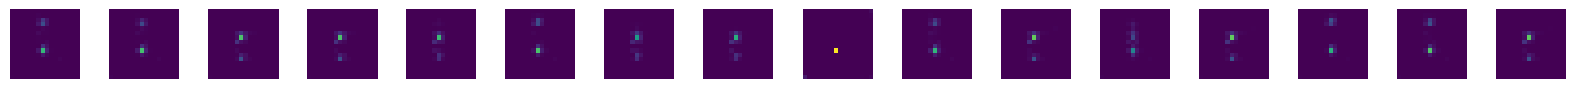

In [ ]:
tracked_fake_dR_mean = []
tracked_fake_dR_std = []
tracked_fake_pixel_mean = []
tracked_fake_pixel_std = []

tracked_real_dR_mean = []
tracked_real_dR_std = []
tracked_real_pixel_mean = []
tracked_real_pixel_std = []

latent_dim = 256
lr = 10e-4
n_epochs = 300
num = 4

generator = Generator(latent_dim).cuda()
discriminator = Discriminator().cuda()

optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.9, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.9, 0.999))

g_losses = []
d_losses = []

# Image shape: (16, 16)
H, W = (16, 16)
center_x, center_y = (W - 1) / 2, (H - 1) / 2

# Coordinate grid
x_coords, y_coords = torch.meshgrid(
    torch.arange(W, dtype=torch.float32),
    torch.arange(H, dtype=torch.float32),
    indexing='ij')

# Distance from center
dists = (torch.sqrt((x_coords - center_x) ** 2 + (y_coords - center_y) ** 2)).cuda()
dists = dists.unsqueeze(0)  # [1, 16, 16]

for epoch in range(n_epochs):
    for i, (real_image, real_features, flipped_image, flipped_features) in enumerate(dataloader):
        
        # All real data are normalized in the dataloader
        real_feat = real_features.cuda()
        real_flipped_feat = flipped_features.cuda()
        real_img = real_image.unsqueeze(1).cuda()
        real_flipped_img = flipped_image.unsqueeze(1).cuda()

        # print(f"Real: {real_img.shape}")

        # Codings should be label, eta, pT, mass that get passed directly to the discriminator
        # Other values are pure noise and get passed to the generator, then those outputs passed to the discriminator

        # Discriminator training
        if i % 3 == 0:
            optimizer_D.zero_grad()
            discriminator.train()
            # Generate fake samples
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).cuda()
            # z_noise = torch.randn(batch_size, 5, ).cuda()
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)
            # print(f"Fake: {fake_img.shape}")

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1
            
            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            real_disc_codings = real_feat[:,:num]
            real_flipped_disc_codings = real_flipped_feat[:,:num]
            fake_disc_codings = z_codings[:,:num]
            fake_flipped_disc_codings = flipped_z_codings[:,:num]

            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
            fake_pred = discriminator(fake_img, fake_disc_codings)
            fake_flipped_pred = discriminator(fake_flipped_img, fake_flipped_disc_codings)

            preds = (torch.cat([real_pred, real_flipped_pred, fake_pred, fake_flipped_pred], dim=0)).squeeze(1)


            # real_labels = torch.empty_like(real_pred).uniform_(0.7, 1.2)
            # fake_labels = torch.empty_like(fake_pred).uniform_(0.0, 0.3)
            # labels = (torch.cat([real_labels, fake_labels], dim=0)).cuda()

            ones = torch.ones(2*len(fake_pred))
            zeros = torch.zeros(2*len(real_pred))
            labels = (torch.cat([ones, zeros], dim=0)).cuda()

            # Discriminator loss is just its ability to distinguish
            d_loss = torch.nn.BCELoss()(preds, labels)

            d_loss.backward()
            optimizer_D.step()

        # Generator Training
        if i % 1 == 0:
            optimizer_G.zero_grad()
            # generator.train()
            
            # Generate fake data
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).cuda()
            # z_noise = torch.randn(batch_size, 5, ).cuda()
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1
            
            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            fake_disc_codings = z_codings[:,:num]
            fake_flipped_disc_codings = flipped_z_codings[:,:num]
            
            # Fooled discriminator loss
            d_out = discriminator(fake_img, fake_disc_codings)
            d_out_flip = discriminator(fake_flipped_img, fake_flipped_disc_codings)
            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
            
            target = torch.ones_like(d_out)
            bce = nn.BCELoss()
            validity_loss = bce(d_out, target) + bce(d_out_flip, target)
            
            # ----- Fake ΔR Calculation -----
            # Original
            # Weighted: pixel * distance / sum(pixel)
            weights = fake_img.squeeze(1)

            dR = (weights * dists)

            fake_dR_mean = dR.mean(dim = (1,2))
            fake_dR_std = dR.std(dim = (1,2))
            
            # Pixel stats
            fake_pixel_mean = weights.mean(dim = (1,2))
            fake_pixel_std = weights.std(dim = (1,2))
            
            # Flipped
            # Weighted: pixel * distance / sum(pixel)
            weights = fake_flipped_img.squeeze(1)
            dR = (weights * dists)

            flipped_dR_mean = dR.mean(dim = (1,2))
            flipped_dR_std = dR.std(dim = (1,2))
            
            # Pixel stats
            flipped_pixel_mean = weights.squeeze(1).mean(dim = (1,2))
            flipped_pixel_std = weights.squeeze(1).std(dim = (1,2))

            real_dR_mean = z_codings[:,5]
            real_dR_std = z_codings[:,6]
            real_pixel_mean = z_codings[:,7]
            real_pixel_std = z_codings[:,8]


            # Statistical MSE loss
            # dR_mean_loss = (torch.nn.MSELoss()(fake_dR_mean, real_dR_mean) + torch.nn.MSELoss()(flipped_dR_mean, real_dR_mean))
            # dR_std_loss = (torch.nn.MSELoss()(fake_dR_std, real_dR_std) + torch.nn.MSELoss()(flipped_dR_std, real_dR_std))
            # pixel_mean_loss = (torch.nn.MSELoss()(fake_pixel_mean, real_pixel_mean) + torch.nn.MSELoss()(flipped_pixel_mean, real_pixel_mean))
            # pixel_std_loss = (torch.nn.MSELoss()(fake_pixel_std, real_pixel_std) + torch.nn.MSELoss()(flipped_pixel_std, real_pixel_std))
            
            # stat_loss = dR_mean_loss + dR_std_loss + 3*pixel_mean_loss + 2*pixel_std_loss

            # print(dR_mean_loss)
            # print(dR_std_loss)
            # print(3*pixel_mean_loss)
            # print(2*pixel_std_loss)

            # Statistical KL Divergence loss
            kl_total = 0
            kl_total += kde_kl_divergence_torch(real_dR_mean, fake_dR_mean) / .001
            kl_total += kde_kl_divergence_torch(real_dR_std, fake_dR_std) / .04
            kl_total += kde_kl_divergence_torch(real_pixel_mean, fake_pixel_mean) / .00003
            kl_total += kde_kl_divergence_torch(real_pixel_std, fake_pixel_std) / .007

            stat_loss = kl_total

            # Number non-zero loss
            fake_nnz = soft_count_nonzero(fake_img, threshold=3e-3, sharpness=10000.0)
            real_nnz = soft_count_nonzero(real_img, threshold=3e-3, sharpness=10000.0)
            nnz_loss = torch.nn.MSELoss()(fake_nnz, real_nnz)

            
            # Total generator loss is the average of the discriminator's predictions of the original and flipped data
            # + the difference between input and output dR and pixel statistics

            alpha = .05
            beta = .00005
            chi = .001

            g_loss = (alpha*validity_loss + beta*nnz_loss + chi*stat_loss)

            g_loss.backward()
            optimizer_G.step()

            if n_epochs - epoch <= 10:
                # Track fake stats
                tracked_fake_dR_mean.append(fake_dR_mean.detach().cpu())
                tracked_fake_dR_std.append(fake_dR_std.detach().cpu())
                tracked_fake_pixel_mean.append(fake_pixel_mean.detach().cpu())
                tracked_fake_pixel_std.append(fake_pixel_std.detach().cpu())
                
                # Track real stats from z_codings
                tracked_real_dR_mean.append(z_codings[:,5].detach().cpu())
                tracked_real_dR_std.append(z_codings[:,6].detach().cpu())
                tracked_real_pixel_mean.append(z_codings[:,7].detach().cpu())
                tracked_real_pixel_std.append(z_codings[:,8].detach().cpu())

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {d_losses[epoch]:.4f}] [G loss: {g_losses[epoch]:.4f}] [Validity_loss: {alpha*validity_loss:.4f}] \n [Stat_loss: {chi*stat_loss:.4f}] [NNZ_loss: {beta*nnz_loss:.4f}]") 

    z_img = torch.randn(batch_size, 256, 1, 1).cuda()

    # Should be very easy to modify which values are passed as codings
    z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                          sample_fit_noise(kdes, num_samples=batch_size)],
                          dim=1).cuda()
    # z_noise = torch.randn(batch_size, 5, ).cuda()
    # z_feat1 = torch.cat([z_codings, z_noise], dim=1)
    z_feat = torch.cat([z_codings], dim=1)

    fake_images = generator(z_feat)
    fake_feat = z_codings
    fake_images.detach().cpu()
    fake_feat.detach().cpu()
    # real_images = next(iter(dataloader))[0][:1000].cpu()

    # output_image = fake_images[:16]  # Save 16 generated samples
    # output_image = (output_image + 1) / 2.0  # Scale to [0, 1]
    # grid = (torchvision.utils.make_grid(output_image, nrow=4, normalize=True)).cpu()
    # np_img = grid.permute(1, 2, 0).numpy()
    # plt.imsave(f'classical_Jet_image_epoch_{epoch}.png', np_img)
    plot_generated_samples(generator, kdes, batch_size=16, latent_dim=256)

plot_metrics(g_losses, d_losses)

# Flatten all batches
fake_dR_mean_vals = torch.cat(tracked_fake_dR_mean).numpy() / batch_size
fake_dR_std_vals = torch.cat(tracked_fake_dR_std).numpy() / batch_size
fake_pixel_mean_vals = torch.cat(tracked_fake_pixel_mean).numpy() / batch_size
fake_pixel_std_vals = torch.cat(tracked_fake_pixel_std).numpy() / batch_size

real_dR_mean_vals = torch.cat(tracked_real_dR_mean).numpy() / batch_size
real_dR_std_vals = torch.cat(tracked_real_dR_std).numpy() / batch_size
real_pixel_mean_vals = torch.cat(tracked_real_pixel_mean).numpy() / batch_size
real_pixel_std_vals = torch.cat(tracked_real_pixel_std).numpy() / batch_size

fig, axs = plt.subplots(1, 4, figsize=(24, 6))  # 4 stats

stat_titles = ['ΔR Mean', 'ΔR Std', 'Pixel Mean', 'Pixel Std']
real_stats = [real_dR_mean_vals, real_dR_std_vals, real_pixel_mean_vals, real_pixel_std_vals]
fake_stats = [fake_dR_mean_vals, fake_dR_std_vals, fake_pixel_mean_vals, fake_pixel_std_vals]

for row in range(4):
    ax = axs[row]

    real_vals = real_stats[row]
    fake_vals = fake_stats[row]

    # Compute limits
    lower = min(np.percentile(real_vals, 1), np.percentile(fake_vals, 1))
    upper = max(np.percentile(real_vals, 99), np.percentile(fake_vals, 99))

    # Truncate values
    real_vals_trunc = real_vals[(real_vals >= lower) & (real_vals <= upper)]
    fake_vals_trunc = fake_vals[(fake_vals >= lower) & (fake_vals <= upper)]

    # Plot
    ax.hist(real_vals_trunc, bins=1000, alpha=0.6, label='Real',
            edgecolor='black', density=True, histtype='stepfilled')
    ax.hist(fake_vals_trunc, bins=1000, alpha=0.6, label='Fake',
            edgecolor='black', density=True, histtype='stepfilled')

    ax.set_xlim(lower, upper)
    ax.set_title(f"{stat_titles[row]}")
    ax.legend()

plt.tight_layout()
plt.suptitle("Real vs Fake Distributions by Statistic", fontsize=16, y=1.02)
plt.show()

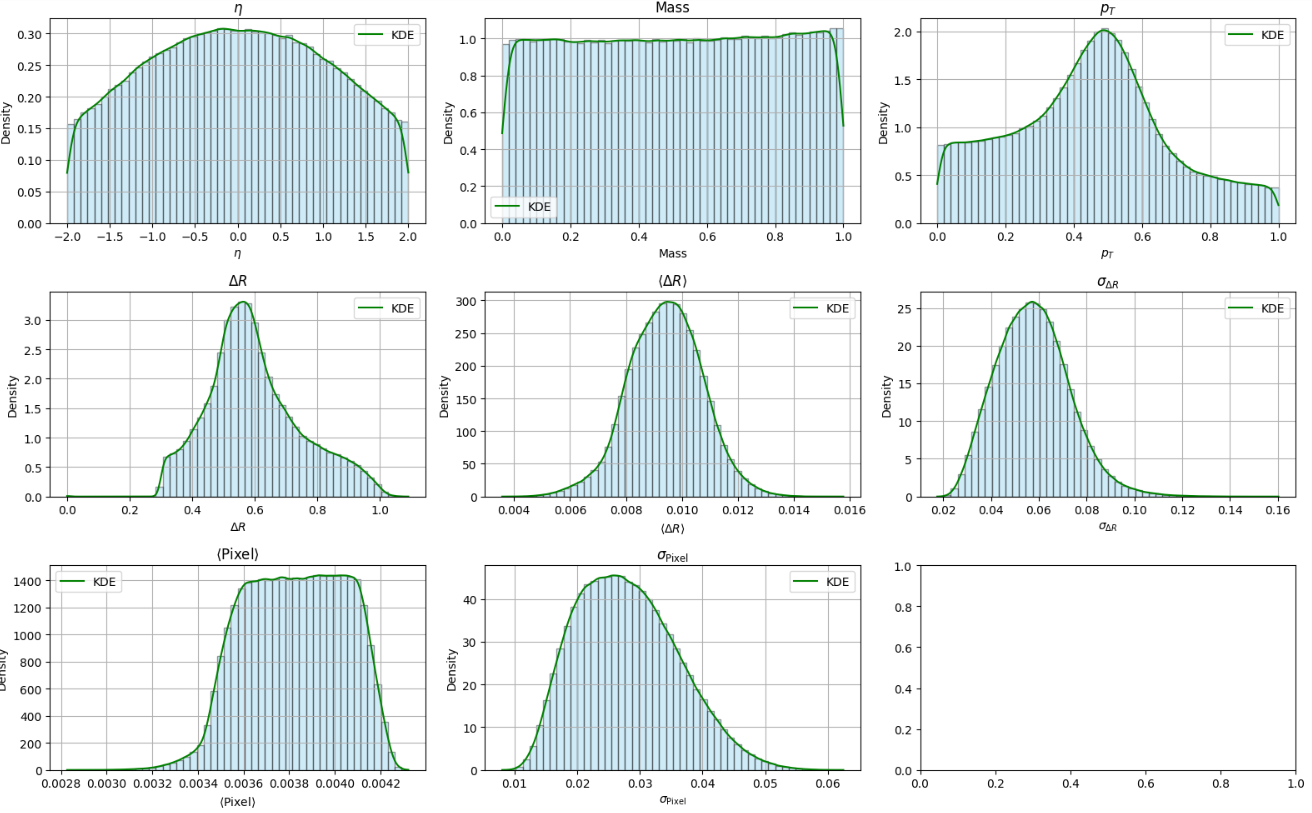

In [ ]:
n_rows, n_cols = 4, 16
n_images = n_rows * n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows * 1.5))

vmin = dataset.images[:n_images].min()
vmax = dataset.images[:n_images].max()

# Show images and keep the first imshow object for colorbar
im = None
for i in range(n_images):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    im = ax.imshow(dataset.images[i], cmap='viridis', vmin=vmin, vmax=vmax)
    ax.axis('off')

# Add a single colorbar on the right of the grid
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [ ]:
def test_generated_samples(generator, kdes, batch_size=4, latent_dim=256, codings = None):
    generator.eval()  # Set to eval mode to disable dropout/batchnorm updates

    # Latent vectors
    z_img = torch.randn(batch_size, latent_dim, 1, 1).cuda()
    # Should be very easy to modify which values are passed as codings
    z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                          sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                          dim=1).cuda()
    # z_noise = torch.randn(batch_size, 5, ).cuda()
    # z_feat = torch.cat([z_codings, z_noise], dim=1)
    z_feat = z_codings

    with torch.no_grad():
        gen_samples = generator(z_feat)

    gen_samples = gen_samples.cpu()
    
    print("Sample feature coding:", z_codings[1].cpu().numpy())

    fig, axes = plt.subplots(1, min(batch_size, 16), figsize=(min(batch_size, 16), 1))
    for i in range(min(batch_size, 16)):
        axes[i].imshow(gen_samples[i, 0].numpy(), cmap= 'viridis')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
    generator.train()  # Restore training mode

# add discriminator test for classification, compare label codings for generator

In [ ]:
test_generated_samples(generator, kdes, batch_size=16, latent_dim=256, codings = [0., 1.1214281, 0.7953802, 0.9241728,  0.69733775, 0.0033828, 0.01578446, 0.00170709, 0.02212167])
n=16

pred1 = discriminator(dataset.images[:n].unsqueeze(1).cuda(), dataset.features[:n,:4].cuda())
print(pred1)
new_dataset = dataset.features[:n,:4].clone()
new_dataset[:n, 0] *= (-2**(new_dataset[:n, 0])+2)

pred2 = discriminator(dataset.images[:n].unsqueeze(1).cuda(), new_dataset[:n,:4].cuda())
print(pred2)

print((pred1/pred2 - 1)*100)